In [60]:
import os
import warnings
warnings.simplefilter(action = 'ignore', category=FutureWarning)
warnings.filterwarnings('ignore')
def ignore_warn(*args, **kwargs):
    pass

warnings.warn = ignore_warn #ignore annoying warning (from sklearn and seaborn)

import numpy as np
import pandas as pd
import pylab 
import seaborn as sns
sns.set(style="ticks", color_codes=True, font_scale=1.5)
from matplotlib import pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from matplotlib.colors import ListedColormap
%matplotlib inline
import mpl_toolkits
from mpl_toolkits.mplot3d import Axes3D
from graphviz import Source
from IPython.display import Image

from scipy.stats import skew, norm, probplot, boxcox, f_oneway
from scipy import interp
from sklearn.base import BaseEstimator, TransformerMixin, clone, ClassifierMixin
from sklearn import metrics, tree
from sklearn.preprocessing import LabelEncoder, label_binarize, StandardScaler, PolynomialFeatures, MinMaxScaler

from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold, cross_val_predict, train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, auc, accuracy_score

from sklearn.linear_model import LogisticRegression
#from keras.models import Sequential
#from keras.layers import Dense
#from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.tree import DecisionTreeClassifier
#import xgboost as xgb
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.ensemble.gradient_boosting import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
#from mlxtend.classifier import StackingClassifier

from skater.core.local_interpretation.lime.lime_tabular import LimeTabularExplainer
from skater.core.explanations import Interpretation
from skater.model import InMemoryModel

In [61]:
wines = pd.read_csv('../../NumericData/winequality.csv')

wines['quality_label'] = wines.quality.apply(lambda q: 'low' if q <= 5 else 'medium' if q <= 7 else 'high')
#wines.quality_label = pd.Categorical(wines.quality_label, categories=['low', 'medium', 'high'], ordered=True)

# re-shuffle records just to randomize data points
wines = wines.sample(frac=1, random_state=101).reset_index(drop=True)
wines.shape

(6497, 14)

In [62]:
wines_orginal = pd.read_csv('../../NumericData/10_noisy_winequality.csv')

wines_orginal['quality_label'] = wines_orginal.quality.apply(lambda q: 'low' if q <= 5 else 'medium' if q <= 7 else 'high')
#wines.quality_label = pd.Categorical(wines.quality_label, categories=['low', 'medium', 'high'], ordered=True)

# re-shuffle records just to randomize data points
wines_orginal = wines_orginal.sample(frac=1, random_state=101).reset_index(drop=True)
wines_orginal.shape

(6497, 14)

In [63]:
def rstr(df, pred=None): 
    obs = df.shape[0]
    types = df.dtypes
    counts = df.apply(lambda x: x.count())
    uniques = df.apply(lambda x: [x.unique()])
    nulls = df.apply(lambda x: x.isnull().sum())
    distincts = df.apply(lambda x: x.unique().shape[0])
    missing_ration = (df.isnull().sum()/ obs) * 100
    skewness = df.skew()
    kurtosis = df.kurt() 
    print('Data shape:', df.shape)
    
    if pred is None:
        cols = ['types', 'counts', 'distincts', 'nulls', 'missing ration', 'uniques', 'skewness', 'kurtosis']
        str = pd.concat([types, counts, distincts, nulls, missing_ration, uniques, skewness, kurtosis], axis = 1)

    else:
        corr = df.corr()[pred]
        str = pd.concat([types, counts, distincts, nulls, missing_ration, uniques, skewness, kurtosis, corr], axis = 1, sort=False)
        corr_col = 'corr '  + pred
        cols = ['types', 'counts', 'distincts', 'nulls', 'missing_ration', 'uniques', 'skewness', 'kurtosis', corr_col ]
    
    str.columns = cols
    dtypes = str.types.value_counts()
    print('___________________________\nData types:\n',str.types.value_counts())
    print('___________________________')
    return str

In [64]:
details = rstr(wines, 'quality')
details.sort_values(by='missing_ration', ascending=False)

Data shape: (6497, 14)
___________________________
Data types:
 float64    11
object      2
int64       1
Name: types, dtype: int64
___________________________


,types,counts,distincts,nulls,missing_ration,uniques,skewness,kurtosis,corr quality
fixed acidity,float64,6487,107,10,0.153917,"[[7.3, 6.9, 9.5, 8.2, 7.9, 9.8, 7.0, 7.2, 6.5,...",1.722805,5.057727,-0.077031
pH,float64,6488,109,9,0.138525,"[[3.28, 3.51, 3.12, 3.31, 3.27, 3.19, 3.05, 3....",0.386966,0.370068,0.019366
volatile acidity,float64,6489,188,8,0.123134,"[[0.28, 1.09, 0.46, 0.31, 0.34, 0.13, 0.25, 0....",1.495512,2.827081,-0.265953
sulphates,float64,6493,112,4,0.061567,"[[0.82, 0.43, 0.74, 0.68, 0.51, 0.55, 0.38, 0....",1.798467,8.659892,0.038729
citric acid,float64,6494,90,3,0.046175,"[[0.42, 0.06, 0.24, 0.4, 0.41, 0.39, 0.37, 0.2...",0.473032,2.401582,0.085706
residual sugar,float64,6495,317,2,0.030783,"[[14.4, 2.1, 2.7, 2.2, 4.9, 1.4, 12.85, 2.0, 1...",1.435000,4.358134,-0.036825
chlorides,float64,6495,215,2,0.030783,"[[0.04, 0.061, 0.092, 0.057999999999999996, 0....",5.399849,50.894874,-0.200886
type,object,6497,2,0,0.000000,"[[white, red]]",NaN,NaN,NaN
free sulfur dioxide,float64,6497,135,0,0.000000,"[[49.0, 12.0, 14.0, 6.0, 31.0, 3.0, 36.0, 55.0...",1.220066,7.906238,0.055463
total sulfur dioxide,float64,6497,276,0,0.000000,"[[173.0, 31.0, 44.0, 10.0, 153.0, 7.0, 105.0, ...",-0.001177,-0.371664,-0.041385


In [65]:
class DataFrameImputer(TransformerMixin):

    def __init__(self):
        """
        Impute missing values:
        - Columns of dtype object are imputed with the most frequent value in column.
        - Columns of other types are imputed with mean of column.
        """
    def fit(self, X, y=None):

        self.fill = pd.Series([X[c].value_counts().index[0]
            if X[c].dtype == np.dtype('O') else X[c].mean() for c in X],
            index=X.columns)

        return self

    def transform(self, X, y=None):
        return X.fillna(self.fill)

wines_orginal = DataFrameImputer().fit_transform(wines_orginal)
wines_orginal.head()

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,quality_label
0,white,7.30,0.28,0.42,14.4,0.040,49.0,173.0,0.99940,3.28,0.82,9.00,7,medium
1,red,6.31,1.09,0.06,2.1,0.200,12.0,31.0,0.99480,3.51,0.43,12.01,4,low
2,red,9.50,0.46,0.24,2.7,0.092,14.0,44.0,0.99800,3.12,0.74,10.00,6,medium
3,red,8.20,0.31,0.40,2.2,0.058,6.0,10.0,0.99536,3.31,0.68,11.20,7,medium
4,white,7.90,0.28,0.41,4.9,0.350,31.0,153.0,0.99660,3.27,0.51,9.70,6,medium


In [66]:
details = rstr(wines_orginal, 'quality')
details.sort_values(by='missing_ration', ascending=False)

Data shape: (6497, 14)
___________________________
Data types:
 float64    11
object      2
int64       1
Name: types, dtype: int64
___________________________


,types,counts,distincts,nulls,missing_ration,uniques,skewness,kurtosis,corr quality
type,object,6497,2,0,0.0,"[[white, red]]",NaN,NaN,NaN
fixed acidity,float64,6497,544,0,0.0,"[[7.3, 6.31, 9.5, 8.2, 7.9, 9.8, 7.0, 7.2, 6.5...",1.982057,4.905649,-0.055474
volatile acidity,float64,6497,232,0,0.0,"[[0.28, 1.09, 0.46, 0.31, 0.34, 0.13, 0.68, 0....",2.204771,5.811307,-0.146289
citric acid,float64,6497,166,0,0.0,"[[0.42, 0.06, 0.24, 0.4, 0.41, 0.39, 0.37, 0.2...",2.391306,7.679797,0.041232
residual sugar,float64,6497,876,0,0.0,"[[14.4, 2.1, 2.7, 2.2, 4.9, 1.4, 12.85, 2.0, 1...",3.056832,10.364656,-0.026693
chlorides,float64,6497,241,0,0.0,"[[0.04, 0.2, 0.092, 0.058, 0.35, 0.066, 0.042,...",3.553892,12.848390,-0.059524
free sulfur dioxide,float64,6497,744,0,0.0,"[[49.0, 12.0, 14.0, 6.0, 31.0, 3.0, 36.0, 197....",3.216674,11.308063,0.003193
total sulfur dioxide,float64,6497,887,0,0.0,"[[173.0, 31.0, 44.0, 10.0, 153.0, 7.0, 105.0, ...",1.135370,2.592745,-0.053061
density,float64,6497,970,0,0.0,"[[0.9994, 0.9948, 0.998, 0.99536, 0.9966, 0.99...",3.345365,12.970688,-0.111030
pH,float64,6497,131,0,0.0,"[[3.28, 3.51, 3.12, 3.31, 3.27, 3.19, 3.05, 3....",0.773303,1.496639,0.009749


In [67]:
wines.quality_label.value_counts()

medium    3915
low       2384
high       198
Name: quality_label, dtype: int64

In [68]:
wines_orginal.quality_label.value_counts()

medium    3915
low       2384
high       198
Name: quality_label, dtype: int64

In [69]:
wines.dropna().quality_label.value_counts()

medium    3894
low       2372
high       197
Name: quality_label, dtype: int64

In [70]:
wines_orginal.dropna().quality_label.value_counts()

medium    3915
low       2384
high       198
Name: quality_label, dtype: int64

In [71]:
class DataFrameImputer(TransformerMixin):

    def __init__(self):
        """
        Impute missing values:
        - Columns of dtype object are imputed with the most frequent value in column.
        - Columns of other types are imputed with mean of column.
        """
    def fit(self, X, y=None):

        self.fill = pd.Series([X[c].value_counts().index[0]
            if X[c].dtype == np.dtype('O') else X[c].mean() for c in X],
            index=X.columns)

        return self

    def transform(self, X, y=None):
        return X.fillna(self.fill)

wines = DataFrameImputer().fit_transform(wines)

In [72]:
#Descriptive Statistics_ByType
subset_attributes = wines.columns
rs = round(wines.loc[wines.type == 'red', subset_attributes].describe(),2)
ws = round(wines.loc[wines.type == 'white', subset_attributes].describe(),2)
pd.concat([rs, ws], axis=0, keys=['Red Wine Statistics', 'White Wine Statistics']).T

Red Wine Statistics                                    \
                                   count   mean    std   min    25%    50%   
fixed acidity                     1599.0   8.32   1.74  4.60   7.10   7.90   
volatile acidity                  1599.0   0.53   0.18  0.12   0.39   0.52   
citric acid                       1599.0   0.27   0.19  0.00   0.09   0.26   
residual sugar                    1599.0   2.54   1.41  0.90   1.90   2.20   
chlorides                         1599.0   0.09   0.05  0.01   0.07   0.08   
free sulfur dioxide               1599.0  15.87  10.46  1.00   7.00  14.00   
total sulfur dioxide              1599.0  46.47  32.90  6.00  22.00  38.00   
density                           1599.0   1.00   0.00  0.99   1.00   1.00   
pH                                1599.0   3.31   0.15  2.74   3.21   3.31   
sulphates                         1599.0   0.66   0.17  0.33   0.55   0.62   
alcohol                           1599.0  10.42   1.07  8.40   9.50  10.20   
quality                           1599.0   5.64   0.81  3.00   5.00   6.00   

                                    White Wine Statistics                 \
                        75%     max                 count    mean    std   
fixed acidity          9.20   15.90                4898.0    6.86   0.84   
volatile acidity       0.64    1.58                4898.0    0.28   0.10   
citric acid            0.42    1.00                4898.0    0.33   0.12   
residual sugar         2.60   15.50                4898.0    6.39   5.07   
chlorides              0.09    0.61                4898.0    0.05   0.02   
free sulfur dioxide   21.00   72.00                4898.0   35.31  17.01   
total sulfur dioxide  62.00  289.00                4898.0  138.36  42.50   
density                1.00    1.00                4898.0    0.99   0.00   
pH                     3.40    4.01                4898.0    3.19   0.15   
sulphates              0.73    2.00                4898.0    0.49   0.11   
alcohol               11.10   14.90                4898.0   10.51   1.23   
quality                6.00    8.00                4898.0    5.88   0.89   

                                                            
                       min     25%     50%     75%     max  
fixed acidity         3.80    6.30    6.80    7.30   14.20  
volatile acidity      0.08    0.21    0.26    0.32    1.10  
citric acid           0.00    0.27    0.32    0.39    1.66  
residual sugar        0.60    1.70    5.20    9.90   65.80  
chlorides             0.01    0.04    0.04    0.05    0.35  
free sulfur dioxide   2.00   23.00   34.00   46.00  289.00  
total sulfur dioxide  9.00  108.00  134.00  167.00  440.00  
density               0.99    0.99    0.99    1.00    1.04  
pH                    2.72    3.09    3.18    3.28    3.82  
sulphates             0.22    0.41    0.47    0.55    1.08  
alcohol               8.00    9.50   10.40   11.40   14.20  
quality               3.00    5.00    6.00    6.00    9.00

In [73]:
#Descriptive Statistics_ByType
subset_attributes = wines_orginal.columns
rs = round(wines_orginal.loc[wines_orginal.type == 'red', subset_attributes].describe(),2)
ws = round(wines_orginal.loc[wines_orginal.type == 'white', subset_attributes].describe(),2)
pd.concat([rs, ws], axis=0, keys=['Red Wine Statistics', 'White Wine Statistics']).T

Red Wine Statistics                                    \
                                   count   mean    std   min    25%    50%   
fixed acidity                     1745.0   8.33   2.05  3.80   7.00   7.80   
volatile acidity                  1745.0   0.52   0.24  0.10   0.36   0.50   
citric acid                       1745.0   0.33   0.29  0.00   0.13   0.29   
residual sugar                    1745.0   6.13  11.57  0.80   1.90   2.30   
chlorides                         1745.0   0.10   0.09  0.01   0.07   0.08   
free sulfur dioxide               1745.0  28.47  42.94  1.00   9.00  16.00   
total sulfur dioxide              1745.0  73.43  76.41  6.00  25.00  47.00   
density                           1745.0   1.00   0.01  0.99   1.00   1.00   
pH                                1745.0   3.30   0.19  2.74   3.18   3.30   
sulphates                         1745.0   0.67   0.25  0.23   0.53   0.61   
alcohol                           1745.0  10.49   1.22  8.04   9.50  10.20   
quality                           1745.0   5.67   0.83  3.00   5.00   6.00   

                                    White Wine Statistics                 \
                        75%     max                 count    mean    std   
fixed acidity          9.26   15.90                4752.0    7.18   1.63   
volatile acidity       0.64    1.58                4752.0    0.33   0.23   
citric acid            0.45    1.65                4752.0    0.38   0.24   
residual sugar         3.31   65.78                4752.0    8.82  10.65   
chlorides              0.09    0.61                4752.0    0.07   0.10   
free sulfur dioxide   28.00  288.66                4752.0   46.66  46.35   
total sulfur dioxide  93.00  436.85                4752.0  146.66  63.81   
density                1.00    1.04                4752.0    1.00   0.01   
pH                     3.40    4.01                4752.0    3.21   0.19   
sulphates              0.73    2.00                4752.0    0.55   0.26   
alcohol               11.20   14.90                4752.0   10.61   1.36   
quality                6.00    9.00                4752.0    5.87   0.88   

                                                            
                       min     25%     50%     75%     max  
fixed acidity         3.80    6.30    6.90    7.50   15.89  
volatile acidity      0.08    0.22    0.27    0.35    1.58  
citric acid           0.00    0.27    0.32    0.42    1.66  
residual sugar        0.60    1.80    6.10   11.50   65.80  
chlorides             0.01    0.04    0.04    0.05    0.61  
free sulfur dioxide   2.00   24.00   35.00   50.00  289.00  
total sulfur dioxide  7.18  107.00  136.00  174.00  440.00  
density               0.99    0.99    0.99    1.00    1.04  
pH                    2.72    3.08    3.18    3.30    4.00  
sulphates             0.22    0.42    0.49    0.58    2.00  
alcohol               8.00    9.50   10.40   11.50   14.89  
quality               3.00    5.00    6.00    6.00    9.00

In [74]:
#Descriptive Statistics_ByQuality
#subset_attributes = ['alcohol', 'volatile acidity', 'pH', 'quality']
ls = round(wines[wines['quality_label'] == 'low'][subset_attributes].describe(),2)
ms = round(wines[wines['quality_label'] == 'medium'][subset_attributes].describe(),2)
hs = round(wines[wines['quality_label'] == 'high'][subset_attributes].describe(),2)
pd.concat([ls, ms, hs], axis=0, keys=['Low Quality Wine', 'Medium Quality Wine', 'High Quality Wine']).T


Low Quality Wine                                      \
                                count    mean    std   min    25%     50%   
fixed acidity                  2384.0    7.33   1.27  4.20   6.50    7.10   
volatile acidity               2384.0    0.40   0.19  0.10   0.26    0.34   
citric acid                    2384.0    0.30   0.16  0.00   0.21    0.30   
residual sugar                 2384.0    5.65   4.92  0.60   1.80    2.90   
chlorides                      2384.0    0.06   0.04  0.01   0.04    0.05   
free sulfur dioxide            2384.0   29.48  19.84  2.00  14.00   26.00   
total sulfur dioxide           2384.0  119.28  61.89  6.00  68.00  124.00   
density                        2384.0    1.00   0.00  0.99   0.99    1.00   
pH                             2384.0    3.21   0.16  2.74   3.11    3.20   
sulphates                      2384.0    0.52   0.14  0.25   0.44    0.50   
alcohol                        2384.0    9.87   0.84  8.00   9.30    9.60   
quality                        2384.0    4.88   0.36  3.00   5.00    5.00   

                                     Medium Quality Wine           ...    \
                         75%     max               count    mean   ...     
fixed acidity           7.80   15.90              3915.0    7.16   ...     
volatile acidity        0.50    1.58              3915.0    0.31   ...     
citric acid             0.40    1.00              3915.0    0.33   ...     
residual sugar          8.52   23.50              3915.0    5.33   ...     
chlorides               0.08    0.61              3915.0    0.05   ...     
free sulfur dioxide    42.00  289.00              3915.0   30.96   ...     
total sulfur dioxide  167.00  440.00              3915.0  113.51   ...     
density                 1.00    1.00              3915.0    0.99   ...     
pH                      3.31    3.90              3915.0    3.22   ...     
sulphates               0.58    2.00              3915.0    0.54   ...     
alcohol                10.40   14.90              3915.0   10.81   ...     
quality                 5.00    5.00              3915.0    6.28   ...     

                                     High Quality Wine                        \
                         75%     max             count    mean    std    min   
fixed acidity           7.60   15.60             198.0    6.86   1.14   3.90   
volatile acidity        0.36    1.04             198.0    0.29   0.12   0.12   
citric acid             0.39    1.66             198.0    0.33   0.10   0.03   
residual sugar          7.90   65.80             198.0    5.35   4.16   0.80   
chlorides               0.06    0.42             198.0    0.04   0.02   0.01   
free sulfur dioxide    41.00  112.00             198.0   34.51  17.08   3.00   
total sulfur dioxide  150.00  294.00             198.0  117.48  41.69  12.00   
density                 1.00    1.04             198.0    0.99   0.00   0.99   
pH                      3.32    4.01             198.0    3.23   0.16   2.88   
sulphates               0.61    1.95             198.0    0.51   0.16   0.25   
alcohol                11.70   14.20             198.0   11.69   1.27   8.50   
quality                 7.00    7.00             198.0    8.03   0.16   8.00   

                                                     
                        25%     50%     75%     max  
fixed acidity          6.22    6.85    7.30   12.60  
volatile acidity       0.21    0.28    0.35    0.85  
citric acid            0.28    0.32    0.37    0.74  
residual sugar         2.00    4.05    7.57   14.80  
chlorides              0.03    0.04    0.04    0.12  
free sulfur dioxide   24.00   34.00   43.00  105.00  
total sulfur dioxide  96.00  118.50  145.00  212.50  
density                0.99    0.99    0.99    1.00  
pH                     3.13    3.23    3.33    3.72  
sulphates              0.38    0.48    0.60    1.10  
alcohol               11.00   12.00   12.60   14.00  
quality                8.00    8.00    8.00    9.00  


In [75]:
#Descriptive Statistics_ByQuality
#subset_attributes = ['alcohol', 'volatile acidity', 'pH', 'quality']
ls = round(wines_orginal[wines_orginal['quality_label'] == 'low'][subset_attributes].describe(),2)
ms = round(wines_orginal[wines_orginal['quality_label'] == 'medium'][subset_attributes].describe(),2)
hs = round(wines_orginal[wines_orginal['quality_label'] == 'high'][subset_attributes].describe(),2)
pd.concat([ls, ms, hs], axis=0, keys=['Low Quality Wine', 'Medium Quality Wine', 'High Quality Wine']).T

Low Quality Wine                                      \
                                count    mean    std   min    25%     50%   
fixed acidity                  2384.0    7.61   1.81  3.82   6.60    7.20   
volatile acidity               2384.0    0.43   0.24  0.08   0.26    0.35   
citric acid                    2384.0    0.36   0.27  0.00   0.21    0.31   
residual sugar                 2384.0    8.72  11.73  0.60   1.90    4.34   
chlorides                      2384.0    0.09   0.10  0.01   0.04    0.05   
free sulfur dioxide            2384.0   41.57  48.52  2.00  15.00   28.00   
total sulfur dioxide           2384.0  132.14  80.64  6.00  72.00  130.00   
density                        2384.0    1.00   0.01  0.99   0.99    1.00   
pH                             2384.0    3.23   0.20  2.72   3.10    3.20   
sulphates                      2384.0    0.57   0.26  0.23   0.44    0.51   
alcohol                        2384.0   10.01   1.10  8.00   9.30    9.70   
quality                        2384.0    4.88   0.36  3.00   5.00    5.00   

                                     Medium Quality Wine           ...    \
                         75%     max               count    mean   ...     
fixed acidity           8.00   15.90              3915.0    7.43   ...     
volatile acidity        0.56    1.58              3915.0    0.36   ...     
citric acid             0.44    1.65              3915.0    0.38   ...     
residual sugar         11.02   65.78              3915.0    7.74   ...     
chlorides               0.08    0.61              3915.0    0.08   ...     
free sulfur dioxide    48.00  289.00              3915.0   41.81   ...     
total sulfur dioxide  177.00  440.00              3915.0  123.86   ...     
density                 1.00    1.04              3915.0    1.00   ...     
pH                      3.33    4.01              3915.0    3.23   ...     
sulphates               0.61    2.00              3915.0    0.59   ...     
alcohol                10.50   14.90              3915.0   10.87   ...     
quality                 5.00    5.00              3915.0    6.28   ...     

                                     High Quality Wine                       \
                         75%     max             count    mean    std   min   
fixed acidity           7.80   15.89             198.0    7.20   1.84  3.84   
volatile acidity        0.40    1.58             198.0    0.32   0.16  0.12   
citric acid             0.42    1.66             198.0    0.37   0.18  0.03   
residual sugar          9.60   65.80             198.0    7.65   9.26  1.00   
chlorides               0.07    0.61             198.0    0.07   0.11  0.01   
free sulfur dioxide    45.55  288.66             198.0   43.38  43.81  3.00   
total sulfur dioxide  157.00  438.74             198.0  126.84  67.29  7.18   
density                 1.00    1.04             198.0    0.99   0.01  0.99   
pH                      3.34    4.01             198.0    3.23   0.20  2.72   
sulphates               0.65    1.99             198.0    0.55   0.26  0.23   
alcohol                11.80   14.89             198.0   11.64   1.38  8.13   
quality                 7.00    7.00             198.0    8.03   0.16  8.00   

                                                     
                        25%     50%     75%     max  
fixed acidity          6.20    6.90    7.57   14.63  
volatile acidity       0.21    0.28    0.37    1.43  
citric acid            0.28    0.33    0.40    1.55  
residual sugar         2.10    4.45    9.17   61.88  
chlorides              0.03    0.04    0.06    0.60  
free sulfur dioxide   25.25   34.00   45.00  286.89  
total sulfur dioxide  96.00  119.00  150.00  432.13  
density                0.99    0.99    0.99    1.04  
pH                     3.09    3.23    3.35    3.96  
sulphates              0.38    0.48    0.64    1.83  
alcohol               10.92   11.96   12.60   14.77  
quality                8.00    8.00    8.00    9.00  

[12 rows x 24

In [76]:
# re-shuffle records just to randomize data points
wines = wines.sample(frac=1, random_state=101).reset_index(drop=True)

class_tp = LabelEncoder()
y_tp = class_tp.fit_transform(wines.type.values) # 1 - White; 0 - Red
wines['color'] = y_tp

class_ql = {'low':0, 'medium': 1, 'high': 2}
y_ql = wines.quality_label.map(class_ql)

In [77]:
# re-shuffle records just to randomize data points
wines_orginal = wines_orginal.sample(frac=1, random_state=101).reset_index(drop=True)

class_tp = LabelEncoder()
y_tp = class_tp.fit_transform(wines_orginal.type.values) # 1 - White; 0 - Red
wines_orginal['color'] = y_tp

class_ql = {'low':0, 'medium': 1, 'high': 2}
y_ql = wines_orginal.quality_label.map(class_ql)

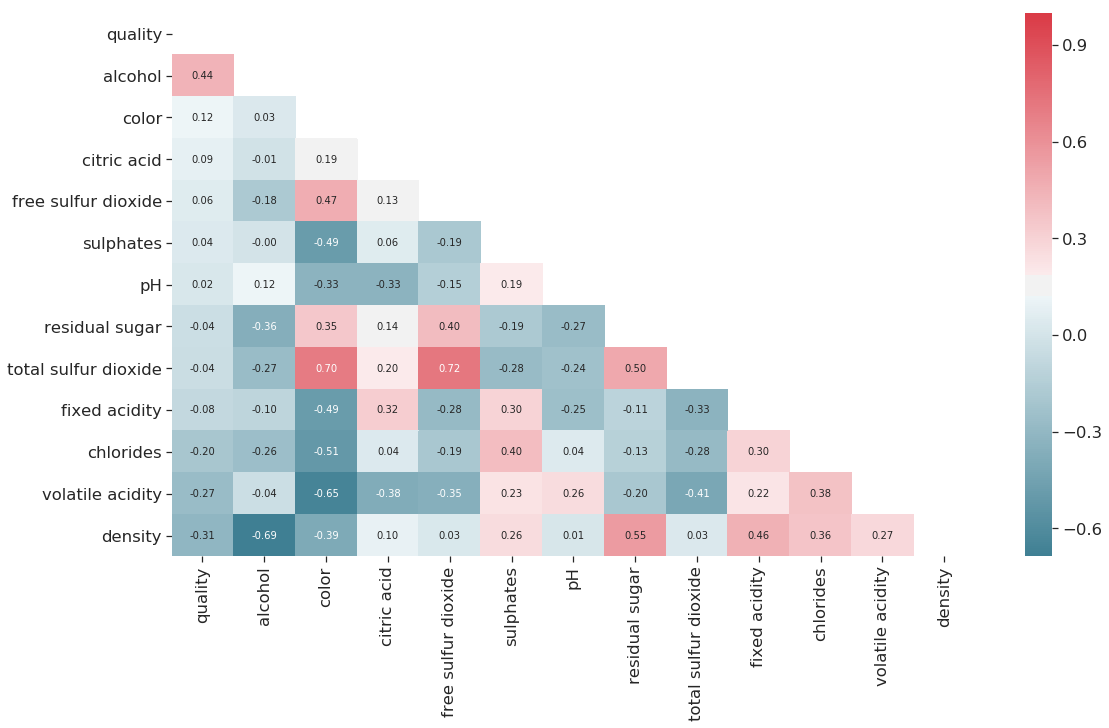

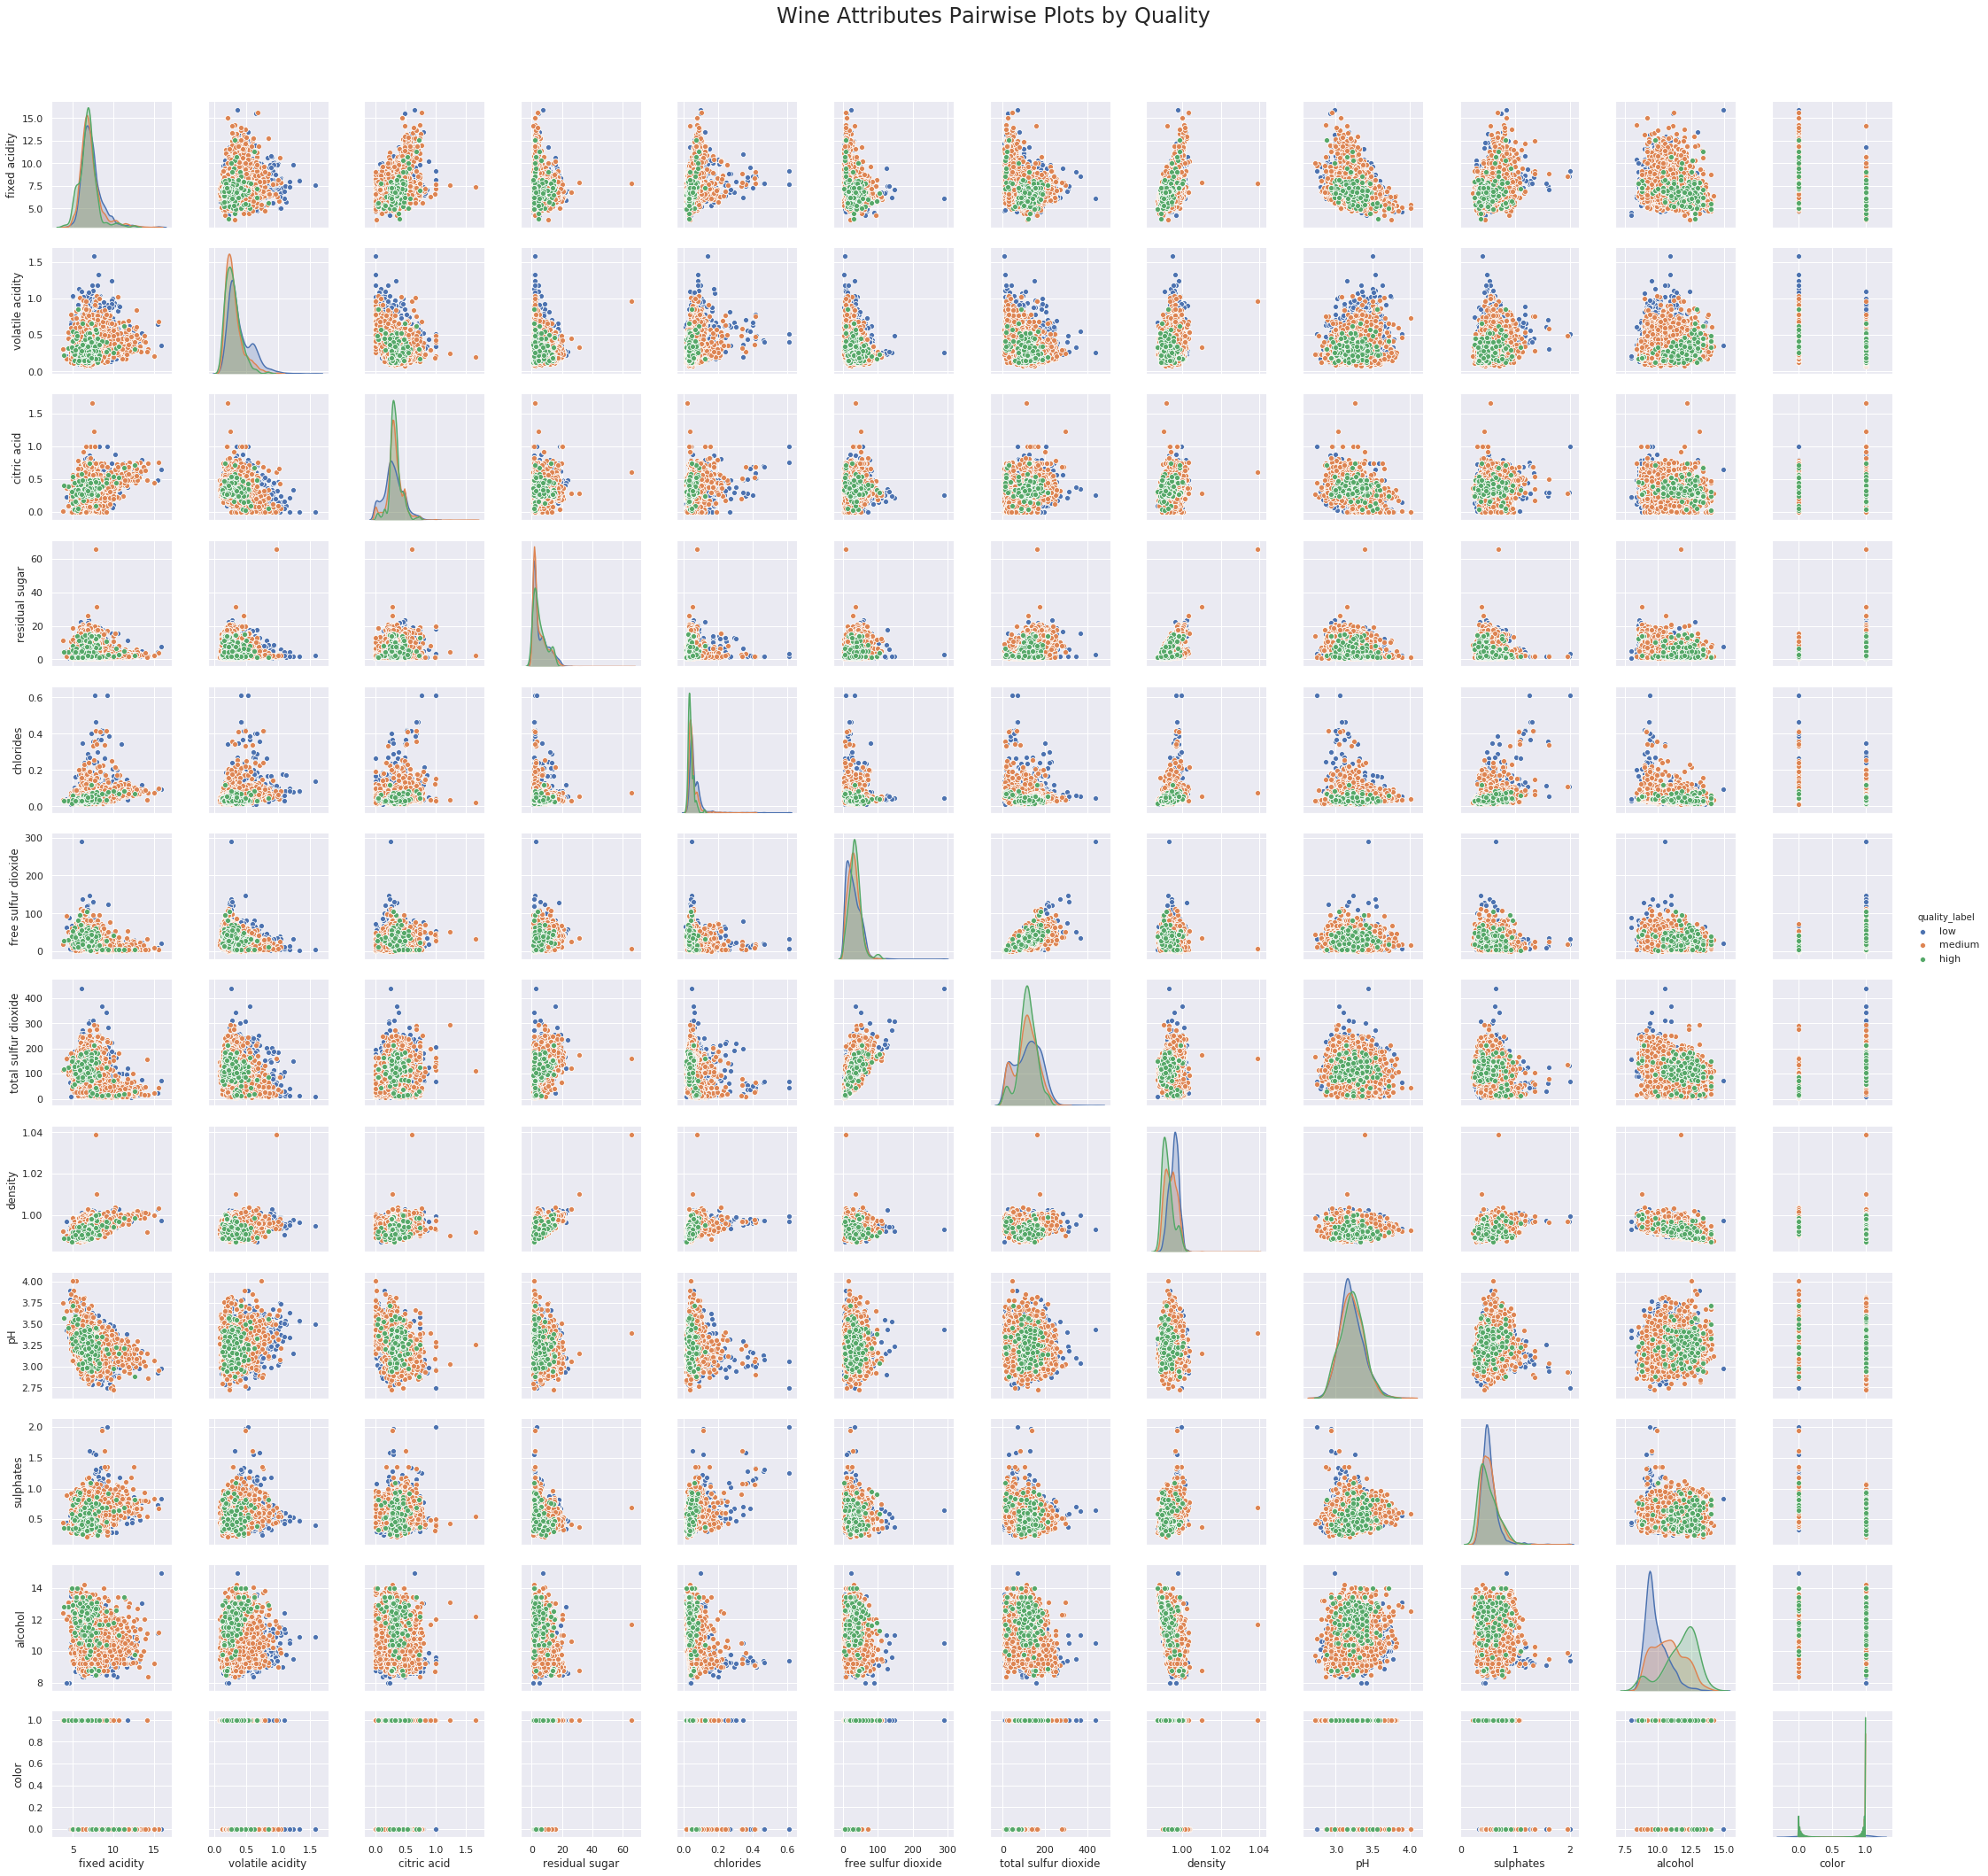

In [78]:
corr = wines.corr()
top_corr_cols = corr.quality.sort_values(ascending=False).keys() 
top_corr = corr.loc[top_corr_cols, top_corr_cols]
dropSelf = np.zeros_like(top_corr)
dropSelf[np.triu_indices_from(dropSelf)] = True
plt.figure(figsize=(18, 10))
sns.heatmap(top_corr, cmap=sns.diverging_palette(220, 10, as_cmap=True), annot=True, fmt=".2f", mask=dropSelf)
sns.set(font_scale=1.5)

sns.set(font_scale=1.0)
cols = wines.columns
cols = cols.drop('quality')
g = sns.pairplot(data = wines.loc[:, cols], hue='quality_label')
fig = g.fig 
fig.subplots_adjust(top=0.93, wspace=0.3)
t = fig.suptitle('Wine Attributes Pairwise Plots by Quality', fontsize=24)

plt.show()

del corr, dropSelf, top_corr, g, fig, t

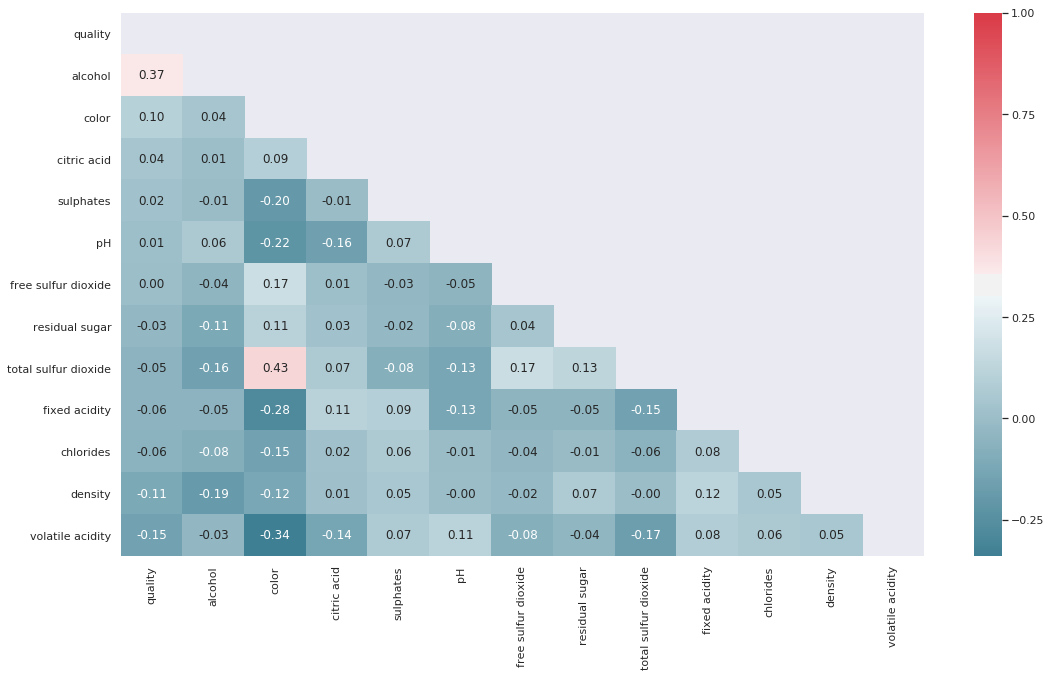

In [ ]:
corr = wines_orginal.corr()
top_corr_cols = corr.quality.sort_values(ascending=False).keys() 
top_corr = corr.loc[top_corr_cols, top_corr_cols]
dropSelf = np.zeros_like(top_corr)
dropSelf[np.triu_indices_from(dropSelf)] = True
plt.figure(figsize=(18, 10))
sns.heatmap(top_corr, cmap=sns.diverging_palette(220, 10, as_cmap=True), annot=True, fmt=".2f", mask=dropSelf)
sns.set(font_scale=1.5)

sns.set(font_scale=1.0)
cols = wines_orginal.columns
cols = cols.drop('quality')
g = sns.pairplot(data = wines_orginal.loc[:, cols], hue='quality_label')
fig = g.fig 
fig.subplots_adjust(top=0.93, wspace=0.3)
t = fig.suptitle('Wine Attributes Pairwise Plots by Quality', fontsize=24)

plt.show()

del corr, dropSelf, top_corr, g, fig, t

In [ ]:
numeric_features = list(wines.dtypes[(wines.dtypes != "str") & (wines.dtypes !='object')].index)
numeric_features.remove('color')

skewed_features = wines[numeric_features].apply(lambda x : skew (x.dropna())).sort_values(ascending=False)

#compute skewness
skewness = pd.DataFrame({'Skew' :skewed_features})   

# Get only higest skewed features
skewness = skewness[abs(skewness) > 0.7]
skewness = skewness.dropna()
print ("There are {} higest skewed numerical features to box cox transform".format(skewness.shape[0]))

l_opt = {}

for feat in skewness.index:
    wines[feat], l_opt[feat] = boxcox((wines[feat]+1))

skewed_features2 = wines[skewness.index].apply(lambda x : skew (x.dropna())).sort_values(ascending=False)

#compute skewness
skewness2 = pd.DataFrame({'New Skew' :skewed_features2})   
display(pd.concat([skewness, skewness2], axis=1).sort_values(by=['Skew'], ascending=False))

In [ ]:
numeric_features = list(wines_orginal.dtypes[(wines_orginal.dtypes != "str") & (wines_orginal.dtypes !='object')].index)
numeric_features.remove('color')

skewed_features = wines_orginal[numeric_features].apply(lambda x : skew (x.dropna())).sort_values(ascending=False)

#compute skewness
skewness = pd.DataFrame({'Skew' :skewed_features})   

# Get only higest skewed features
skewness = skewness[abs(skewness) > 0.7]
skewness = skewness.dropna()
print ("There are {} higest skewed numerical features to box cox transform".format(skewness.shape[0]))

l_opt = {}

for feat in skewness.index:
    wines_orginal[feat], l_opt[feat] = boxcox((wines_orginal[feat]+1))

skewed_features2 = wines_orginal[skewness.index].apply(lambda x : skew (x.dropna())).sort_values(ascending=False)

#compute skewness
skewness2 = pd.DataFrame({'New Skew' :skewed_features2})   
display(pd.concat([skewness, skewness2], axis=1).sort_values(by=['Skew'], ascending=False))

In [ ]:
from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor

def VRF(predict, data, y):
   
    scale = StandardScaler(with_std=False)
    df = pd.DataFrame(scale.fit_transform(data), columns= cols)
    print(df.shape)
    print(len(y))
    features = "+".join(cols)
    df['quality_label'] = y.values

    # get y and X dataframes based on this regression:
    y, X = dmatrices(predict + ' ~' + features, data = df, return_type='dataframe')

   # Calculate VIF Factors
    # For each X, calculate VIF and save in dataframe
    vif = pd.DataFrame()
    vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif["features"] = X.columns

    # Inspect VIF Factors
    display(vif.sort_values('VIF Factor'))
    return vif

cols = wines_orginal.columns.str.replace(' ', '_')
df = wines_orginal.copy()
df.columns = cols
# Remove the not applied to the qualty classification task
cols = list(cols.drop(['type', 'quality_label', 'quality']))

vif = VRF('quality_label', df.loc[:, cols], y_ql)

In [ ]:
from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor

def VRF(predict, data, y):
   
    scale = StandardScaler(with_std=False)
    df = pd.DataFrame(scale.fit_transform(data), columns= cols)
    features = "+".join(cols)
    print(df.shape)
    print(len(y))
    df['quality_label'] = y.values

    # get y and X dataframes based on this regression:
    y, X = dmatrices(predict + ' ~' + features, data = df, return_type='dataframe')

   # Calculate VIF Factors
    # For each X, calculate VIF and save in dataframe
    vif = pd.DataFrame()
    vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif["features"] = X.columns

    # Inspect VIF Factors
    display(vif.sort_values('VIF Factor'))
    return vif

cols = wines.columns.str.replace(' ', '_')

print(wines.shape)
df.columns = cols
# Remove the not applied to the qualty classification task
cols = list(cols.drop(['type', 'quality_label', 'quality']))

vif = VRF('quality_label', df.loc[:, cols], y_ql)


In [ ]:
cols = wines.columns.str.replace(' ', '_')
df = wines.copy()
df.columns = cols
# Remove the higest correlations and run a multiple regression
cols = list(cols.drop(['type', 'quality_label', 'quality', 'residual_sugar', 'total_sulfur_dioxide']))

vif = VRF('quality_label', df.loc[:, cols], y_ql)

del df, vif

In [ ]:

cols = wines_orginal.columns.str.replace(' ', '_')
df = wines_orginal.copy()
df.columns = cols
# Remove the higest correlations and run a multiple regression
cols = list(cols.drop(['type', 'quality_label', 'quality', 'residual_sugar', 'total_sulfur_dioxide']))

vif = VRF('quality_label', df.loc[:, cols], y_ql)

del df, vif

In [ ]:
wqp_class_labels = np.array(wines['quality_label'])
target_names = ['low', 'medium', 'high']

cols = wines.columns
cols = list(cols.drop(['type', 'quality_label', 'quality']))
X_train,X_test, y_train, y_test = train_test_split(wines.loc[:, cols], y_ql.values, test_size=0.20, random_state=35)



In [ ]:
wqp_class_labels = np.array(wines['quality_label'])
target_names = ['low', 'medium', 'high']

cols = wines_orginal.columns
cols = list(cols.drop(['type', 'quality_label', 'quality']))
X_train_original, X_test_original, y_train_original, y_test_original = train_test_split(wines_orginal.loc[:, cols], y_ql.values, test_size=0.20, random_state=35)
#print(X_test_orginal)
#np.any(np.isnan(X_test_orginal))

In [ ]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model.fit(X_train,y_train)
y_pred = model.predict(X_test_original)

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

cm = confusion_matrix(y_test_original, y_pred)
print(cm)
print(accuracy_score(y_test_original, y_pred))
print(f1_score(y_test_original, y_pred,average='weighted'))